In [1]:
from matplotlib import colors as m_colors
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yaml import load as load_yaml, FullLoader

from datamodule import KIDataModule
from models.inceptiontime import LitInceptionTimeModel
from utils.const import SEED
from utils.misc import set_random_state
from utils.path import config_path, checkpoint_path

set_random_state(SEED)
!conda activate eyetrackpdc

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\neptune\internal\backends\hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\loggers\neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


### Load Configs

In [2]:
with open(config_path.joinpath('leif.yaml')) as reader:
    processor_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('transformer.yaml')) as reader:
    transformer_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('inception.yaml')) as reader:
    inception_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('neptune.yaml')) as reader:
    neptune_config = load_yaml(reader, Loader=FullLoader)

### Prepare Data (segments)

In [3]:
dm = KIDataModule(
    processor_config=processor_config,
    use_triplets=True,
    binary_classification=True,
    batch_size=256
)
dm.setup(stage='fit')

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-train.pth


### Initialize Models

In [4]:
inception_time = LitInceptionTimeModel(**inception_config)
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, perplexity=30)

### Train InceptionTime using Triplet Loss

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\hejpa\Documents\GitHub\eye-track-pdc\checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-train.pth


C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\torch\nn\modules\conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  self.padding, self.dilation, self.groups)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at C:\Users\hejpa\Documents\GitHub\eye-track-pdc\src\.lr_find_b5c0febf-1bde-4bc2-a881-0ea30c480c9e.ckpt
Restored all states from the checkpoint file at C:\Users\hejpa\Documents\GitHub\eye-track-pdc\src\.lr_find_b5c0febf-1bde-4bc2-a881-0ea30c480c9e.ckpt
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


0.0001


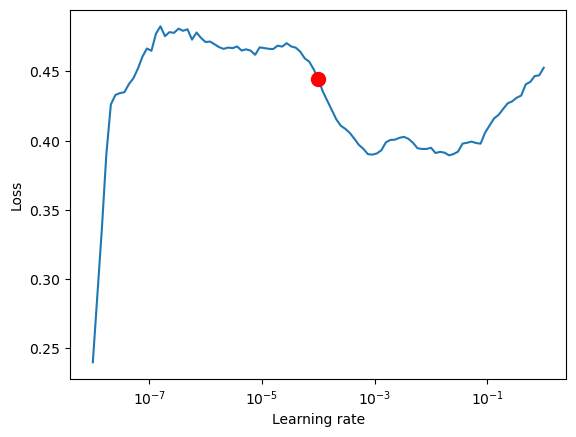

In [5]:
trainer = Trainer(accelerator='auto',
                  max_epochs=100,
                  logger=NeptuneLogger(log_model_checkpoints=True, **neptune_config),
                  callbacks=[LearningRateMonitor(),
                             ModelCheckpoint(dirpath=checkpoint_path, monitor='val_loss', every_n_epochs=5),
                             ],  #EarlyStopping(monitor='val_loss', patience=20)],
                  log_every_n_steps=1)

trainer.fit(inception_time, datamodule=dm)

### Visualize embeddings for validation set

In [5]:
from utils.data import normalize

# Use the best model in terms of validation loss
inception_time = LitInceptionTimeModel.load_from_checkpoint(checkpoint_path.joinpath('epoch=44-step=180-v1.ckpt'))

dm.set_use_triplets(False)
dm.batch_size = -1
complete_train_set = next(iter(dm.train_dataloader()))
complete_val_set = next(iter(dm.val_dataloader()))

embeddings = inception_time(complete_val_set.x)
normalized_embeddings = normalize(embeddings.detach())
proj = pca.fit_transform(normalized_embeddings.detach(), complete_val_set.y)
manifold = tsne.fit_transform(proj)

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\torch\nn\modules\conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  self.padding, self.dilation, self.groups)
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


['52.95%', '16.46%', '9.96%', '6.02%', '5.08%', '2.08%', '1.45%', '1.13%', '0.89%', '0.71%', '0.60%', '0.49%', '0.36%', '0.28%', '0.24%', '0.20%', '0.16%', '0.14%', '0.12%', '0.11%', '0.09%', '0.08%', '0.07%', '0.06%', '0.05%', '0.04%', '0.03%', '0.03%', '0.03%', '0.02%', '0.02%', '0.01%', '0.01%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
['52.95%', '69.41%', '79.37%', '85.39%', '90.47%', '92.55%', '94.00%', '95.13%', '96.02%', '96.73

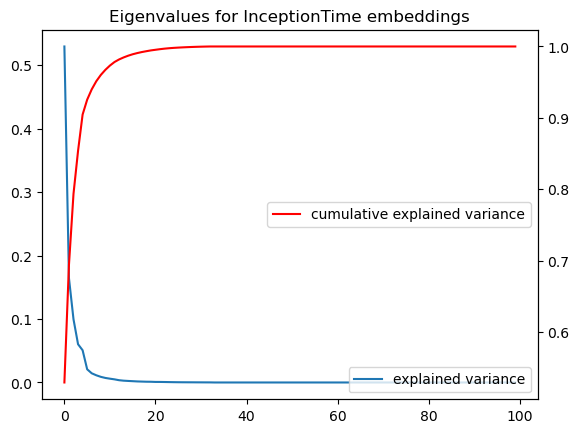

In [6]:
from utils.data import normalize
import numpy as np
from numpy import arange
from numpy.linalg import svd

normalized = normalize(embeddings.detach())

u, sigma, v_t = np.linalg.svd(normalized, full_matrices=False)

# Compute eigenvalues from singular values
eigenvalues = sigma ** 2 / np.sum(sigma ** 2)

# sorted_eigenvalues = flip()
top_eigenvalues = eigenvalues[:100]
explained_information = [sum(eigenvalues[:i]) for i in range(1, len(top_eigenvalues) + 1)]

print([f'{v:.2%}' for v in top_eigenvalues])
print([f'{val:.2%}' for val in explained_information])

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(arange(len(top_eigenvalues)), top_eigenvalues, label='explained variance')
ax2.plot(arange(len(explained_information)), explained_information, label='cumulative explained variance', c='r')
ax.set_title('Eigenvalues for InceptionTime embeddings')
ax.legend(loc='lower right')
ax2.legend(loc='center right')
plt.show()

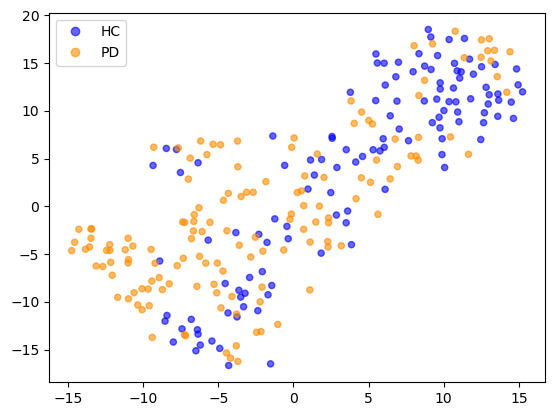

In [7]:
labels = ['HC', 'PD']
colors = ['blue', 'darkorange']
cmap = m_colors.ListedColormap(colors)
scatter = plt.scatter(manifold[:, 0], manifold[:, 1], c=complete_val_set.y, s=20, alpha=0.6, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()